In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Small_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Large_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Medium_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Medium_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Medium_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Large_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Medium_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Large_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Large_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Small_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Trans.csv
/kaggle/input/ibm-

## **Load Libraries**

In [2]:
import datetime
import os
from typing import Callable, Optional
import pandas as pd
from sklearn import preprocessing
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')


## **Load Extracted Dataset**
At first we were working with the [IBM Transaction Dataset](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml), but working with that dataset were taking a lot of time as well as we could not properly work with the dataset because of `out of memory` issue. 
So we extracted the `Laundering Transactions` from all the 6 datasets and concatenated the `Laundering Transactions` with `LI-Medium_Transaction` dataset. You can check the code for extracting dataset [here](https://www.kaggle.com/code/rafsunsheikh/extract-aml-data). 
After the extraction, we downloaded the dataset and uploaded as Kaggle Dataset [IBM_Anti_Money_Laundering_dataset_Extracted](https://www.kaggle.com/datasets/rafsunsheikh/ibm-anti-money-laundering-dataset-extracted) for your use.
Now, we will work with the `IBM_Anti_Money_Laundering_dataset_Extracted` for ease of work.

In [3]:
path = '/kaggle/input/ibm-anti-money-laundering-dataset-extracted/LI-Medium_and_all_filtered.csv'
df = pd.read_csv(path)

### **Rearrange the dataset**
**We found that, the ratio of `laundering Transactions` and `non-laundering Transactions` are too dissimilar which will impact on the training of the model. So let's try to rearrange and create a new dataset with a bit more data amount similarities.**

In [4]:
# Filter the rows
laundering_1 = df[df['Is Laundering'] == 1]
laundering_0 = df[df['Is Laundering'] == 0]

# Randomly sample 500,000 rows from the 'Is Laundering' == 0 transactions
sampled_0 = laundering_0.sample(n=500000, random_state=42)

# Combine the sampled 'Is Laundering' == 0 rows with all 'Is Laundering' == 1 rows
final_df = pd.concat([laundering_1, sampled_0])

# Shuffle the rows in the final dataset
df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

## **Data Visualization**

In [5]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/08/26 15:31,70,100428A08,202550,84B66EE60,1012.38,Saudi Riyal,1012.38,Saudi Riyal,Cash,1
1,2022/09/04 16:43,78903,81ED71850,81805,82026F100,14494269.34,Ruble,14494269.34,Ruble,ACH,0
2,2022/09/12 07:57,1171144,84013C590,174769,840C95200,3898.57,Swiss Franc,3898.57,Swiss Franc,Credit Card,0
3,2022/09/06 13:31,230856,80E316F20,124134,81FCA94D0,358.43,Euro,358.43,Euro,Cheque,0
4,2022/09/12 01:36,2942,80BC97080,1116395,83E4A7810,1429.45,US Dollar,1429.45,US Dollar,Credit Card,0


In [6]:
df.dtypes

Timestamp              object
From Bank               int64
Account                object
To Bank                 int64
Account.1              object
Amount Received       float64
Receiving Currency     object
Amount Paid           float64
Payment Currency       object
Payment Format         object
Is Laundering           int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886163 entries, 0 to 886162
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Timestamp           886163 non-null  object 
 1   From Bank           886163 non-null  int64  
 2   Account             886163 non-null  object 
 3   To Bank             886163 non-null  int64  
 4   Account.1           886163 non-null  object 
 5   Amount Received     886163 non-null  float64
 6   Receiving Currency  886163 non-null  object 
 7   Amount Paid         886163 non-null  float64
 8   Payment Currency    886163 non-null  object 
 9   Payment Format      886163 non-null  object 
 10  Is Laundering       886163 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 74.4+ MB


In [8]:
df.nunique()

Timestamp             142790
From Bank              29624
Account               489627
To Bank                17598
Account.1             612290
Amount Received       598868
Receiving Currency        15
Amount Paid           599588
Payment Currency          15
Payment Format             7
Is Laundering              2
dtype: int64

#### **Check for Null Values**

In [9]:
df.isnull().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

#### **Let's check for any difference between `paid amount` and `received amount`**

In [10]:
print("Amount received equals to Amount Paid:")
print(df['Amount Received'].equals(df['Amount Paid']))

Amount received equals to Amount Paid:
False


#### **Let's check whether `Recieving Currency` equals to `Payment Currency`**

In [11]:
print('Receiving Currency equals to Payment Currency:')
print(df['Receiving Currency'].equals(df['Payment Currency']))

Receiving Currency equals to Payment Currency:
False


#### **Let's find out the transactions with `not equal amount` and `not equal currency`**

In [12]:
not_equal_amount = df.loc[~(df['Amount Received'] == df['Amount Paid'])]
not_equal_currency = df.loc[~(df['Receiving Currency'] == df['Payment Currency'])]

print("Total Transactions: ", len(df))
print("Not Equal Amount Transactions Total: ", len(not_equal_amount))
print("Not Equal Currency Transactions Total: ", len(not_equal_currency))

Total Transactions:  886163
Not Equal Amount Transactions Total:  7506
Not Equal Currency Transactions Total:  7508


In [13]:
filtered_df = df[df['Receiving Currency'] != df['Payment Currency']]
filtered_df

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
384,2022/09/02 15:47,122113,8390F8840,122113,8390F8840,217.47,Swiss Franc,1591.83,Yuan,ACH,0
458,2022/09/10 10:03,26074,8066739F0,26074,8066739F0,56051.38,Yuan,8368.88,US Dollar,ACH,0
461,2022/09/09 03:29,21617,806E4DDA0,21617,806E4DDA0,35186.30,Yuan,4483.40,Euro,ACH,0
836,2022/09/05 20:27,1208,80340A5E0,1208,80340A5E0,76.48,Euro,89.62,US Dollar,ACH,0
1076,2022/09/09 06:56,20,80010E6F0,20,80010E6F0,6619.91,Euro,7757.10,US Dollar,ACH,0
...,...,...,...,...,...,...,...,...,...,...,...
885657,2022/09/16 08:25,242452,811750E40,242452,811750E40,1473.41,Euro,181974.59,Yen,ACH,0
885810,2022/09/05 03:32,4965,80B323430,4965,80B323430,39.67,Euro,46.48,US Dollar,ACH,0
885856,2022/09/06 22:06,2589,81FA6B940,2589,81FA6B940,1277.11,Shekel,378.18,US Dollar,ACH,0
885952,2022/09/13 00:15,1113968,842862F90,1113968,842862F90,31.59,Euro,247.96,Yuan,ACH,0


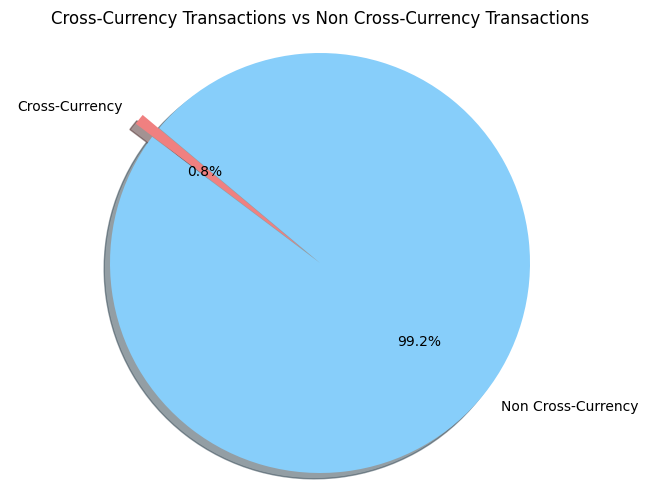

In [14]:
cross_currency_count = len(filtered_df)

total_transactions = len(df)

non_cross_currency_count = total_transactions - cross_currency_count

labels = ['Cross-Currency', 'Non Cross-Currency']
sizes = [cross_currency_count, non_cross_currency_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Non Cross-Currency Transactions')
plt.axis('equal')
plt.show()

#### **Let's find out what are the Different `Currency` Types**

In [15]:
print(sorted(df['Receiving Currency'].unique()))
print(sorted(df['Payment Currency'].unique()))

['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']
['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']


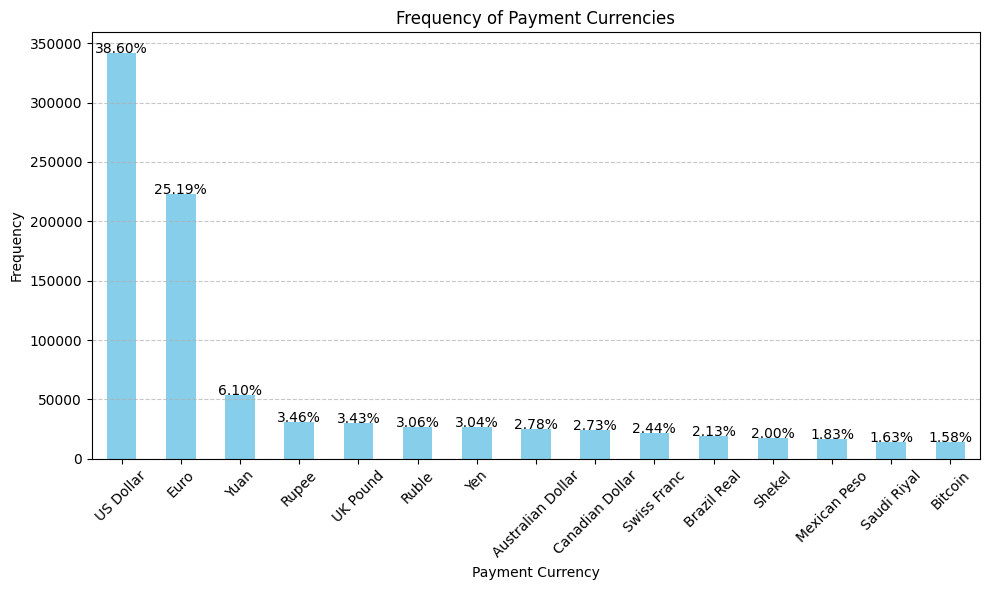

In [16]:
currency_counts = df['Payment Currency'].value_counts()
total_transactions = len(df)
currency_percentage = (currency_counts / total_transactions) * 100

plt.figure(figsize=(10, 6))
bars = currency_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Payment Currencies')
plt.xlabel('Payment Currency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(currency_counts):
    plt.text(i, v + 0.5, f'{currency_percentage.iloc[i]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

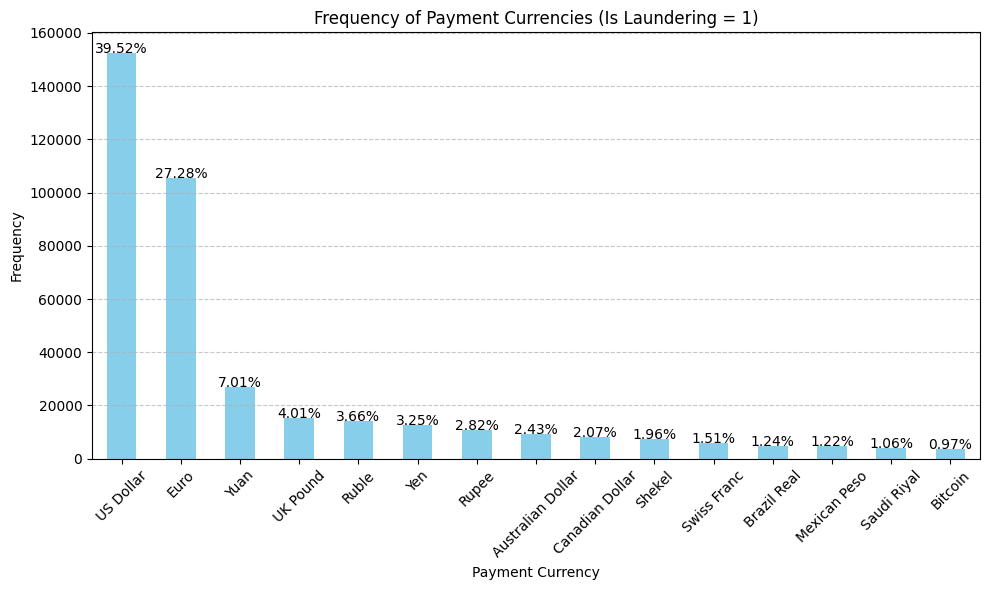

In [17]:
laundering_df = df[df['Is Laundering'] == 1]

currency_counts = laundering_df['Payment Currency'].value_counts()

total_transactions = len(laundering_df)
currency_percentage = (currency_counts / total_transactions) * 100

plt.figure(figsize=(10, 6))
bars = currency_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Payment Currencies (Is Laundering = 1)')
plt.xlabel('Payment Currency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(currency_counts):
    plt.text(i, v + 0.5, f'{currency_percentage.iloc[i]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

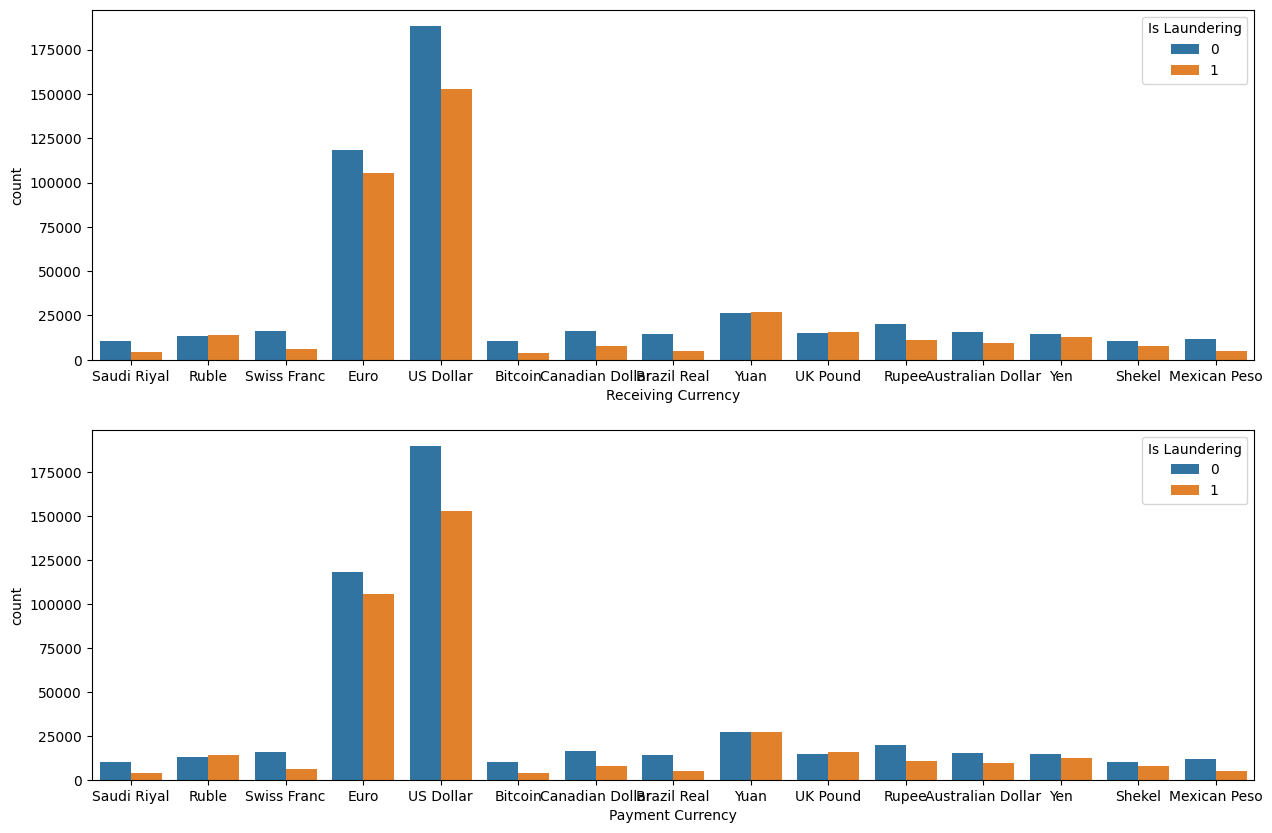

In [18]:
#Plot Categorical VS Target
cate = ["Receiving Currency","Payment Currency"]

fig, axes = plt.subplots(2,1,figsize=(15,10))
for cat, ax in zip(cate, axes.flatten()) :
  sns.countplot(x=cat,data=df,hue="Is Laundering",ax=ax)

Insight: The visualization above is one of the most important when further exploring the data. From this visualization, we can compare the number of money laundering transactions and non-money laundering transactions with the payment currencies they use. It is clear that almost all transactions that are NOT MONEY LAUNDERING (blue bars) use US Dollars as their payment currency. There are only a very few non-money laundering transactions that do not use US Dollars as their payment currency.

However, attention should also be given to the payment currencies used by MONEY LAUNDERING PERPETRATORS (orange bars). Most of them use payment currencies that are spread across various currencies, not just US Dollars, but also Euro, Yuan, UK Pound, and other currencies, which far exceeds the usage in non-money laundering transactions. This indicates that money laundering perpetrators are conducting transactions using currencies beyond just US Dollars, unlike the general population, and are using many currencies that are rarely used by ordinary people.

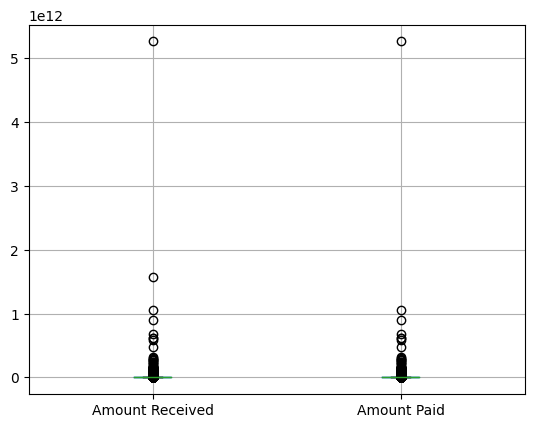

In [19]:
boxplot = df.boxplot(['Amount Received','Amount Paid'])

Insight: The boxplot visualization above is used to identify outliers that we previously identified. The circles with black borders represent outlier values that fall outside the boxplot. This indicates that there are 45 circles with black borders (outliers) where the Amount Received and Amount Paid are significantly higher than most transactions made by ordinary people.

Insight: Most money laundering perpetrators conduct their transactions during the day, around 11:00 AM to 3:00 PM.

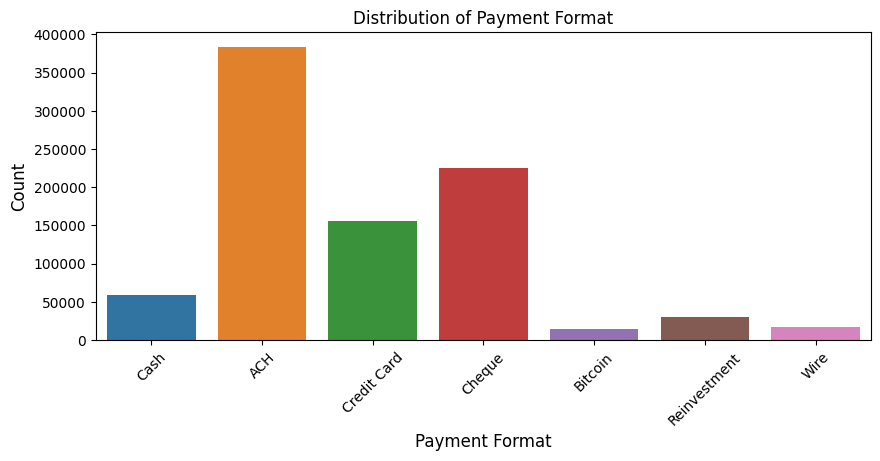

In [20]:
# Payment Format
f, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='Payment Format', data=df, ax=ax)
ax.set_title('Distribution of Payment Format')
ax.set_xlabel('Payment Format', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# Set the x-axis tick labels to the original values
# ax.set_xticklabels(df['Payment Format'].unique())

plt.show()

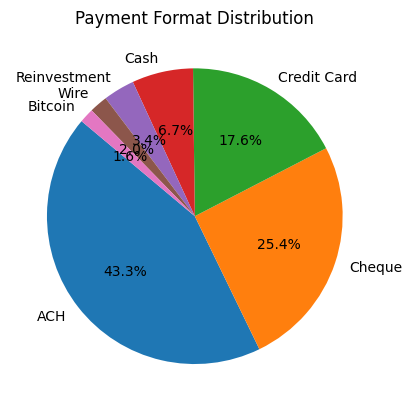

In [21]:
plt.pie(df['Payment Format'].value_counts(), labels=df['Payment Format'].value_counts().index, autopct='%1.1f%%', startangle=140)

plt.title('Payment Format Distribution')

plt.show()

#### **Check the number of transactions from each bank**

In [22]:
df['From Bank'].value_counts()

From Bank
70         103893
11           5165
0            5040
20           4957
12           4537
            ...  
3109741         1
3101078         1
328839          1
334670          1
369285          1
Name: count, Length: 29624, dtype: int64

There are 29,624 different banks data are available here from where money is send.

In [23]:
df['To Bank'].value_counts()

To Bank
20        3680
11        3647
0         3501
12        3343
27        2573
          ... 
32054        1
39687        1
113831       1
310864       1
143968       1
Name: count, Length: 17598, dtype: int64

There are 17,598 different banks are available here to where money is send.

#### **Describe the From and To accounts**

In [24]:
df[['Account', 'Account.1']].describe()

,Account,Account.1
count,886163,886163
unique,489627,612290
top,10042B660,81BBEA160
freq,28696,323


#### **Total counts of Laundering values**

In [25]:
df['Is Laundering'].value_counts()

Is Laundering
0    500000
1    386163
Name: count, dtype: int64

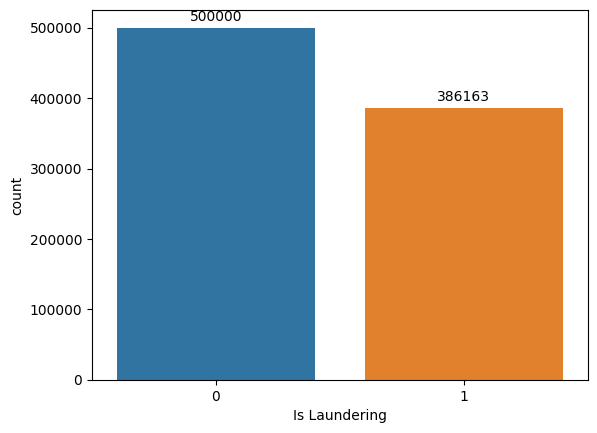

In [26]:
# Create the count plot
ax = sns.countplot(data=df, x='Is Laundering')

# Add count numbers on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'baseline', 
                xytext = (0, 5), 
                textcoords = 'offset points')

# Show the plot
plt.show()

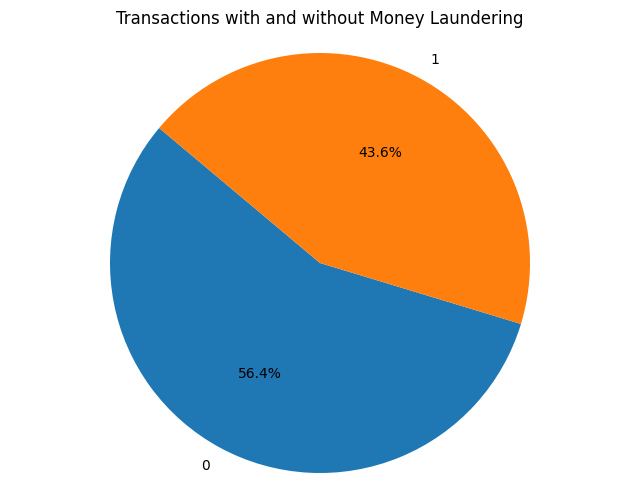

In [27]:
laundering_counts = df['Is Laundering'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(laundering_counts, labels=laundering_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Transactions with and without Money Laundering')
plt.axis('equal')
plt.show()

In [28]:
laundering_df.shape

(386163, 11)

In [29]:
print("This is the total number of laundering transactions in different currencies:\n",currency_counts)

This is the total number of laundering transactions in different currencies:
 Payment Currency
US Dollar            152614
Euro                 105327
Yuan                  27072
UK Pound              15478
Ruble                 14133
Yen                   12556
Rupee                 10901
Australian Dollar      9384
Canadian Dollar        8007
Shekel                 7566
Swiss Franc            5812
Brazil Real            4797
Mexican Peso           4698
Saudi Riyal            4084
Bitcoin                3734
Name: count, dtype: int64


/tmp/ipykernel_33/3022132148.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_laundering_df['Timestamp'] = pd.to_datetime(money_laundering_df['Timestamp'])
/tmp/ipykernel_33/3022132148.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_laundering_df['Day'] = money_laundering_df['Timestamp'].dt.day


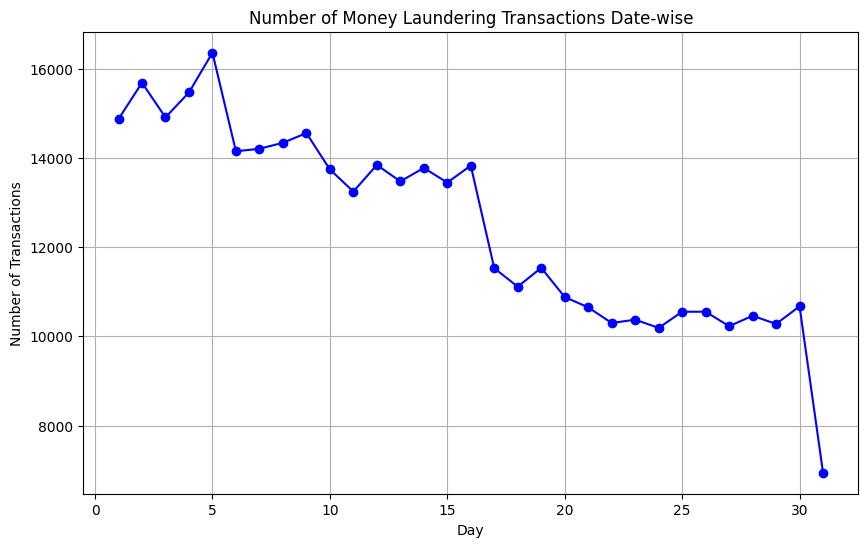

In [30]:
# Assuming df is your DataFrame containing transaction data

# Step 1: Filter money laundering data
money_laundering_df = df[df['Is Laundering'] == 1]

# Step 2: Convert Timestamp column to datetime
money_laundering_df['Timestamp'] = pd.to_datetime(money_laundering_df['Timestamp'])

# Step 3: Extract year from Timestamp
money_laundering_df['Day'] = money_laundering_df['Timestamp'].dt.day

# Step 4: Count number of transactions for each year
transactions_by_year = money_laundering_df.groupby('Day').size()

# Step 5: Visualize the number of transactions year-wise
transactions_by_year.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

### **Check for Outliers** 

An outlier is data that deviates extremely (far) from the average of a dataset. In practice, outliers usually need to be treated specially. Generally, there are two common ways to handle outliers: either by removing them or by replacing them with the mean/average/mode of the dataset. First, let's identify which data points are recognized as outliers.

One method to identify and gather outliers is by searching for data that is either smaller than the mean minus (3 standard deviations) or larger than the mean plus (3 standard deviations). The method below can identify whether a transaction has an outlier value in the 'Amount Received' column or not.

In [31]:
#Identification of Outlier Values
mean = df['Amount Received'].mean()
std = df['Amount Received'].std()
Tmin = mean - (3 * std)
Tmax = mean + (3 * std)

# Display values from the 'Amount Received' column that are less than Tmin or greater than Tmax
filtered_values = df[(df['Amount Received'] < Tmin) | (df['Amount Received'] > Tmax)]['Amount Received'].values
print(filtered_values)

[5.24433079e+10 2.04634787e+10 5.57209040e+10 8.03725930e+10
 2.10073799e+10 3.31319150e+10 4.26410649e+10 3.31445671e+10
 7.30597029e+10 2.86331831e+10 8.88343141e+10 1.95446343e+10
 1.10098194e+11 3.01987286e+11 2.19311672e+10 4.20224101e+10
 7.37428502e+10 1.89701396e+10 1.43280533e+11 4.30735091e+10
 2.25387209e+11 6.17642470e+10 2.15624665e+10 2.88334720e+10
 2.23478731e+10 2.17696960e+10 2.04463775e+10 4.38234061e+10
 4.81577135e+10 2.24022042e+10 2.92897553e+11 5.90743582e+10
 4.39324431e+10 3.78152287e+10 2.09580757e+10 3.25162729e+11
 1.58501655e+11 2.45031168e+10 7.38103718e+10 6.75823099e+10
 1.55215387e+11 1.99201827e+10 2.64656483e+10 4.77892732e+11
 1.13877571e+11 2.46838915e+10 8.48531442e+10 2.35101337e+10
 3.30793830e+10 3.38348793e+10 1.96958384e+10 1.94447599e+10
 2.43018696e+11 5.12549353e+10 1.56510418e+12 2.08898174e+10
 2.42795405e+10 2.15006922e+10 1.21622639e+11 1.40736470e+11
 1.14681755e+11 6.13705983e+10 6.20641790e+10 2.04314907e+10
 1.61880574e+11 3.526593

In [32]:
# Viewing the number of data points identified by filtered_values
number_of_identified_data_points = len(filtered_values)
print("Number of data points identified as Outliers:", number_of_identified_data_points)

Number of data points identified as Outliers: 177


Once we have identified which data points are outliers, the next step is to decide on the special treatment for these outliers (ignore/remove/manipulate). We deliberately chose not to immediately remove the outlier values because we suspect that money laundering perpetrators might receive amounts from source accounts that are unusual or extremely deviating from the average of most people.

To determine what action is reasonable for outliers in this money laundering case, we need to examine how many of the outliers are identified as money laundering and how many are not identified as money laundering.

In [33]:
# Display data that matches in DataFrame format
outliers_dataframe = df[(df['Amount Received'] < Tmin) | (df['Amount Received'] > Tmax)]

# Display the number of unique values in the 'Is Laundering' column from the DataFrame outliers_dataframe
count_is_laundering = outliers_dataframe['Is Laundering'].value_counts()
print("Count of each unique value in the 'Is Laundering' column:\n", count_is_laundering)

Count of each unique value in the 'Is Laundering' column:
 Is Laundering
1    147
0     30
Name: count, dtype: int64


In [34]:
df[df['Amount Received'].isin(filtered_values)]

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
1291,2022/10/17 12:12,1315,804E64130,74925,81C695D00,5.244331e+10,Ruble,5.244331e+10,Ruble,ACH,1
3289,2022/09/07 03:22,13011,80551ED90,13011,80551ED90,2.046348e+10,Rupee,2.786270e+08,US Dollar,ACH,0
7308,2022/09/01 06:20,20511,810DEBAC0,49574,8166F6430,5.572090e+10,Rupee,5.572090e+10,Rupee,ACH,0
15757,2022/10/26 09:47,280694,81DD09A50,26,81DD0A5B0,8.037259e+10,Ruble,8.037259e+10,Ruble,ACH,1
18100,2022/09/03 04:34,87373,821C1F4C0,74925,821C1F5B0,2.100738e+10,Ruble,2.100738e+10,Ruble,ACH,1
...,...,...,...,...,...,...,...,...,...,...,...
857877,2022/10/17 03:08,77009,81CCD0CF0,174147,8064876D0,2.476761e+11,Ruble,2.476761e+11,Ruble,ACH,1
858889,2022/10/22 06:40,150204,813284530,51969,813284580,2.015827e+10,Yen,2.015827e+10,Yen,ACH,1
865401,2022/10/28 23:53,254512,8143CC330,152606,8143CC420,5.745627e+10,Yen,5.745627e+10,Yen,ACH,1
870316,2022/09/03 17:17,23,81219E660,247717,81219E700,3.246696e+10,Yen,3.246696e+10,Yen,ACH,1


### **Feature Selection and Manipulation**

As we know, Machine Learning can only process numerical data. Therefore, it is important for us to wisely select the features available. When there are features that cannot be processed, we need to manipulate them to produce meaningful values.

Based on the data information above, there are several columns that are not of numerical data type:

- Timestamp

- Account

- Account.1

- Receiving Currency

- Payment Currency

- Payment Format

In [35]:
# check data atribute
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

We began by manipulating the 'Timestamp' column. The 'Timestamp' column is an object-type column that stores data in the format Year/Month/Day/Hour/Minute of a transaction. We manipulated the 'Timestamp' column by extracting only the hour and minute into new columns named 'Hour' and 'Minutes', both of integer type.

This was done not without reason, as we suspect that money laundering activities may occur at specific times. Therefore, we converted the 'Timestamp' column, which was initially of object type, to a datetime type.

Once the system recognized the 'Timestamp' column as a datetime type, we created new columns ('Hour' and 'Minutes') to store the hour and minute from the 'Timestamp' column. As a result, the 'Timestamp' column became irrelevant, so we decided to drop it.

In [36]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Access hour and minute attributes using 'dt'
df['Hour'] = df['Timestamp'].dt.hour
df['Minutes'] = df['Timestamp'].dt.minute

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


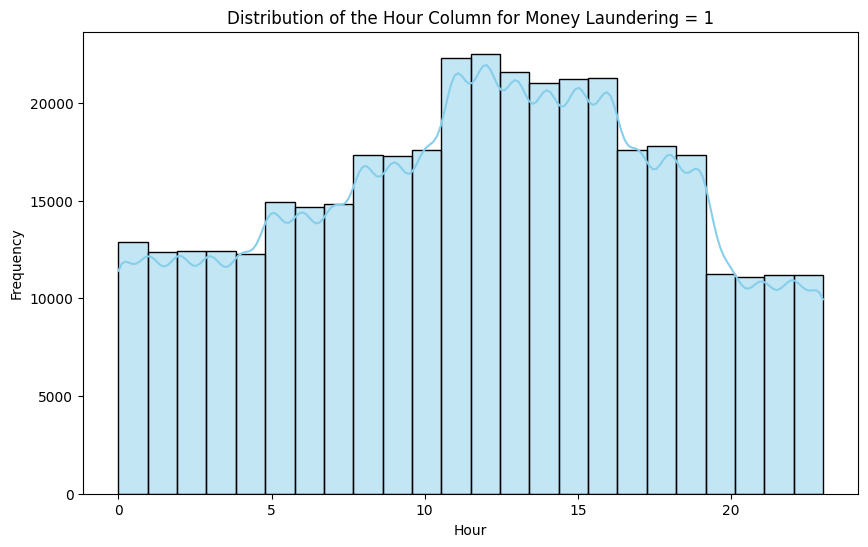

In [37]:
# Filter DataFrame to include only rows where 'Is Laundering' has a value of 1
df_is_laundering_1 = df[df['Is Laundering'] == 1]

# Creating a Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_is_laundering_1, x='Hour', bins=24, kde=True, color='skyblue')
plt.title('Distribution of the Hour Column for Money Laundering = 1')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

Insight: Most of the laundering transactions happened between 10:00 AM to 3:00 PM

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886163 entries, 0 to 886162
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Timestamp           886163 non-null  datetime64[ns]
 1   From Bank           886163 non-null  int64         
 2   Account             886163 non-null  object        
 3   To Bank             886163 non-null  int64         
 4   Account.1           886163 non-null  object        
 5   Amount Received     886163 non-null  float64       
 6   Receiving Currency  886163 non-null  object        
 7   Amount Paid         886163 non-null  float64       
 8   Payment Currency    886163 non-null  object        
 9   Payment Format      886163 non-null  object        
 10  Is Laundering       886163 non-null  int64         
 11  Hour                886163 non-null  int32         
 12  Minutes             886163 non-null  int32         
dtypes: datetime64[ns](1), float64

In [39]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,Minutes
0,2022-08-26 15:31:00,70,100428A08,202550,84B66EE60,1012.38,Saudi Riyal,1012.38,Saudi Riyal,Cash,1,15,31
1,2022-09-04 16:43:00,78903,81ED71850,81805,82026F100,14494269.34,Ruble,14494269.34,Ruble,ACH,0,16,43
2,2022-09-12 07:57:00,1171144,84013C590,174769,840C95200,3898.57,Swiss Franc,3898.57,Swiss Franc,Credit Card,0,7,57
3,2022-09-06 13:31:00,230856,80E316F20,124134,81FCA94D0,358.43,Euro,358.43,Euro,Cheque,0,13,31
4,2022-09-12 01:36:00,2942,80BC97080,1116395,83E4A7810,1429.45,US Dollar,1429.45,US Dollar,Credit Card,0,1,36


In [40]:
#Drop unrelatable columns
df = df.drop(columns=['Timestamp'])

After manipulating the 'Timestamp' column, we turned our attention to the next features, 'Account' and 'Account.1', where 'Account' represents the hexadecimal code of the source transaction account, and 'Account.1' represents the hexadecimal code of the destination transaction account. In this process, we want to determine if there is an effect if a transaction is made from an account to the same account concerning the identification of money laundering transactions.

Therefore, we created a new column named 'Different Account', which will have a value of 0 if the transaction is made to the same account as the sender's account, and a value of 1 if the transaction is made to a different account from the sender's account. After creating the 'Different Account' column, the 'Account' and 'Account.1' columns become irrelevant and can be dropped.

In [41]:
df['Different Account'] = np.where(df['Account'] == df['Account.1'], 0, 1)

In [42]:
df.tail()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,Minutes,Different Account
886158,11032,81BA78340,11081,81BA99030,1686.66,US Dollar,1686.66,US Dollar,ACH,1,9,58,1
886159,53620,813F686A0,6845,813F69C40,2854.53,US Dollar,2854.53,US Dollar,ACH,1,2,36,1
886160,117909,810103DD0,8483,80915E1C0,14625.31,US Dollar,14625.31,US Dollar,ACH,1,11,39,1
886161,70,10042B660,249308,82AFFE0A0,2513.26,US Dollar,2513.26,US Dollar,Cheque,0,23,59,1
886162,6,82210D590,10,821F8B2E0,2965.15,UK Pound,2965.15,UK Pound,ACH,1,16,52,1


In [43]:
#view the number of data entries in the 'Different Account' column
df['Different Account'].value_counts()

Different Account
1    845718
0     40445
Name: count, dtype: int64

Here 1 represents, money is transferred to different account, and 0 represents money is transferred to the same account.

In [44]:
count_1_0 = df[(df['Different Account'] == 1) & (df['Is Laundering'] == 0)]['Is Laundering'].count()
count_0_1 = df[(df['Different Account'] == 0) & (df['Is Laundering'] == 1)]['Is Laundering'].count()
count_1_1 = df[(df['Different Account'] == 1) & (df['Is Laundering'] == 1)]['Is Laundering'].count()
count_0_0 = df[(df['Different Account'] == 0) & (df['Is Laundering'] == 0)]['Is Laundering'].count()

# Displaying the results
print("Total (Different Account=1, Is Laundering=0):", count_1_0)
print("Total (Different Account=0, Is Laundering=1):", count_0_1)
print("Total (Different Account=1, Is Laundering=1):", count_1_1)
print("Total (Different Account=0, Is Laundering=0):", count_0_0)

Total (Different Account=1, Is Laundering=0): 460143
Total (Different Account=0, Is Laundering=1): 588
Total (Different Account=1, Is Laundering=1): 385575
Total (Different Account=0, Is Laundering=0): 39857


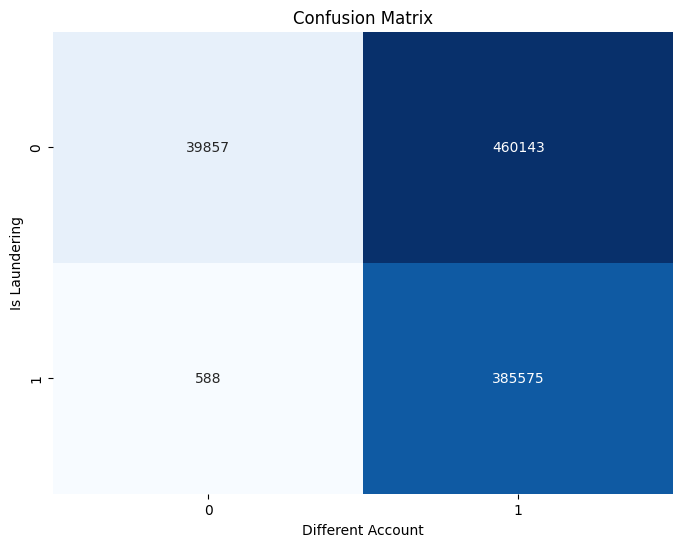

In [45]:


# Creating a confusion matrix
conf_matrix = confusion_matrix(df['Is Laundering'], df['Different Account'])

# Visualizing the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Different Account')
plt.ylabel('Is Laundering')
plt.show()

Initially, we assumed that a transaction occurring from the same account to the same account would be unusual. However, after performing the calculations, it turned out that the impact of transactions from the same account to the same account on identifying money laundering was not very strong. This is based on the confusion matrix, which evaluated the influence of the 'Different Account' column on the 'Is Laundering' column, showing relatively balanced values. There were only 96 instances where a transaction occurred from the same account to the same account and was identified as money laundering. This number is relatively small compared to the others.

In [46]:
#Drop unrelatable columns
df = df.drop(columns=['Account','Account.1'])

In [47]:
df.head()

,From Bank,To Bank,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,Minutes,Different Account
0,70,202550,1012.38,Saudi Riyal,1012.38,Saudi Riyal,Cash,1,15,31,1
1,78903,81805,14494269.34,Ruble,14494269.34,Ruble,ACH,0,16,43,1
2,1171144,174769,3898.57,Swiss Franc,3898.57,Swiss Franc,Credit Card,0,7,57,1
3,230856,124134,358.43,Euro,358.43,Euro,Cheque,0,13,31,1
4,2942,1116395,1429.45,US Dollar,1429.45,US Dollar,Credit Card,0,1,36,1


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886163 entries, 0 to 886162
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   From Bank           886163 non-null  int64  
 1   To Bank             886163 non-null  int64  
 2   Amount Received     886163 non-null  float64
 3   Receiving Currency  886163 non-null  object 
 4   Amount Paid         886163 non-null  float64
 5   Payment Currency    886163 non-null  object 
 6   Payment Format      886163 non-null  object 
 7   Is Laundering       886163 non-null  int64  
 8   Hour                886163 non-null  int32  
 9   Minutes             886163 non-null  int32  
 10  Different Account   886163 non-null  int64  
dtypes: float64(2), int32(2), int64(4), object(3)
memory usage: 67.6+ MB


## **Feature Engineering**
**Our goal in examining the variation in categorical data above is to determine the appropriate feature engineering for each categorical column. As is known, Machine Learning can only process numeric data, so categorical data must be converted into numeric data through feature engineering. Feature engineering includes several methods such as:**

- **Binary Encoding (for converting categorical data with only 2 unique values)**
- **One Hot Encoding (for converting categorical data with more than 2 unique values)**
- **Label Encoding (for converting categorical data into labels that we define)**
- **Frequency Encoding (for converting categorical data into numeric values based on the frequency of each value)**
- **Mean Encoding (for converting categorical data into numeric values based on the mean)**

**NOTES: It is crucial for us to wisely choose the most suitable method for each categorical column.**

In [49]:
df.head()

,From Bank,To Bank,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,Minutes,Different Account
0,70,202550,1012.38,Saudi Riyal,1012.38,Saudi Riyal,Cash,1,15,31,1
1,78903,81805,14494269.34,Ruble,14494269.34,Ruble,ACH,0,16,43,1
2,1171144,174769,3898.57,Swiss Franc,3898.57,Swiss Franc,Credit Card,0,7,57,1
3,230856,124134,358.43,Euro,358.43,Euro,Cheque,0,13,31,1
4,2942,1116395,1429.45,US Dollar,1429.45,US Dollar,Credit Card,0,1,36,1


For the 'Payment Currency' and 'Receiving Currency' columns, we agreed to use frequency encoding. The reason is that the data has considerable variation (with 15 unique values), making binary encoding unsuitable and one-hot encoding potentially burdensome. Additionally, we chose frequency encoding because we want to replace a value with how frequently it appears compared to other unique values.

In [50]:
#Create a Frequency Encoding Function
def frequency_encoding(data,features) :
    freq_encoding=data.groupby(features).size()/len(data)
    return freq_encoding

In [51]:
df['Payment Currency'] = df['Payment Currency'].map(frequency_encoding(df,df['Payment Currency']))

In [52]:
df['Receiving Currency'] = df['Receiving Currency'].map(frequency_encoding(df,df['Receiving Currency']))

For the 'Payment Format' column, we agreed to use one-hot encoding as the feature engineering method because the number of unique values in the 'Payment Format' column is only 7, which is manageable and won't overly burden the machine learning model building process.

In [53]:
#One hot encoding For Payment Format
df = pd.get_dummies(df,columns=['Payment Format'])

In [54]:
df.head()

,From Bank,To Bank,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Is Laundering,Hour,Minutes,Different Account,Payment Format_ACH,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire
0,70,202550,1012.38,0.016417,1012.38,0.016268,1,15,31,1,False,False,True,False,False,False,False
1,78903,81805,14494269.34,0.030773,14494269.34,0.030600,0,16,43,1,True,False,False,False,False,False,False
2,1171144,174769,3898.57,0.024717,3898.57,0.024441,0,7,57,1,False,False,False,False,True,False,False
3,230856,124134,358.43,0.252151,358.43,0.251913,0,13,31,1,False,False,False,True,False,False,False
4,2942,1116395,1429.45,0.384509,1429.45,0.386017,0,1,36,1,False,False,False,False,True,False,False


In [55]:
df.shape

(886163, 17)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886163 entries, 0 to 886162
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   From Bank                    886163 non-null  int64  
 1   To Bank                      886163 non-null  int64  
 2   Amount Received              886163 non-null  float64
 3   Receiving Currency           886163 non-null  float64
 4   Amount Paid                  886163 non-null  float64
 5   Payment Currency             886163 non-null  float64
 6   Is Laundering                886163 non-null  int64  
 7   Hour                         886163 non-null  int32  
 8   Minutes                      886163 non-null  int32  
 9   Different Account            886163 non-null  int64  
 10  Payment Format_ACH           886163 non-null  bool   
 11  Payment Format_Bitcoin       886163 non-null  bool   
 12  Payment Format_Cash          886163 non-null  bool   
 13 

## **Splitting Dataset**
Next, we begin the development of this machine learning model by performing dataset splitting. The purpose of this splitting is to allocate a portion of the data for training our machine learning model and another portion for testing the model to evaluate its accuracy. In this case, we have decided to split the data into 80% for training and 20% for testing.

In [57]:
#spliting dataset
X = df.drop(columns="Is Laundering")
y = df['Is Laundering']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((708930, 16), (177233, 16), (708930,), (177233,))

## **Logistic Regression Model (Default)**
**Since in this money laundering case we aim to predict whether a transaction falls into the money laundering category or not, the model we are developing is a classification model. The goal is for the model to classify whether a transaction is categorized as money laundering or not. The first model we are building is a Logistic Regression model.**

In [58]:
# Train data dengan data training
model_log = LogisticRegression()
model_log.fit(X_train,y_train)

LogisticRegression()

In [59]:
# Viewing the accuracy of the model
model_log.score(X_test,y_test)

0.5646070427064938

In [60]:
y_predict_log=model_log.predict(X_test)

In [61]:
# Displaying the report to evaluate the model's performance

from sklearn.metrics import classification_report
print('\nLogistic Regression Classification Report (Default)\n')
print(classification_report(y_test, y_predict_log))


Logistic Regression Classification Report (Default)

              precision    recall  f1-score   support

           0       0.56      1.00      0.72    100000
           1       0.53      0.01      0.01     77233

    accuracy                           0.56    177233
   macro avg       0.55      0.50      0.37    177233
weighted avg       0.55      0.56      0.41    177233



## **LR Model Improvement : Parameter Tuning**
The Logistic Regression model above is far from optimal as it has an accuracy of 56%. Therefore, we are attempting to perform parameter tuning with GridSearchCV to find which parameters are best used to achieve the highest accuracy. The parameters are 'penalty' and 'C'.

In [62]:
# Tentukan parameter apa saja yang akan dituning
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Inisialisasi model Logistic Regression
modelLogReg = LogisticRegression()

# Gunakan GridSearchCV untuk mencari parameter terbaik
grid_search_logreg = GridSearchCV(modelLogReg, param_grid=parameters, scoring='accuracy', cv=5)
grid_search_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [63]:
# Display the best parameters that can achieve the maximum accuracy produced by the Logistic Regression model
print("Tuned Hyperparameters :", grid_search_logreg.best_params_)
print("Accuracy :",grid_search_logreg.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2'}
Accuracy : 0.564645310538417


In [64]:
#Train data with the Best Parameters
modellog_best = LogisticRegression(C = 0.001, penalty = 'l2')
modellog_best.fit(X_train,y_train)

LogisticRegression(C=0.001)

#### **Logistic Regression Evaluation Matrix**

In [65]:
#testing
y_predict_bestlog = modellog_best.predict(X_test)

In [66]:
print('\nLogistic Regression Classification Report (Tuned)\n')
print(classification_report(y_test, y_predict_bestlog))


Logistic Regression Classification Report (Tuned)

              precision    recall  f1-score   support

           0       0.56      1.00      0.72    100000
           1       0.53      0.01      0.01     77233

    accuracy                           0.56    177233
   macro avg       0.55      0.50      0.37    177233
weighted avg       0.55      0.56      0.41    177233



## **Naive Bayes Model (Default)**
Although the Logistic Regression model above has been optimized with parameter tuning, its accuracy is still well below (0%). Therefore, we conclude that in this case, we cannot use the Logistic Regression model. We will continue searching for the best model with Naive Bayes.

In [67]:
# Training Model
model_nb =MultinomialNB()
model_nb.fit(X_train, y_train)

MultinomialNB()

In [68]:
# View Model Accuracy
model_nb.score(X_test,y_test)

0.5669316662246873

In [69]:
# Testing
y_predict_nb=model_nb.predict(X_test)

In [70]:
from sklearn.metrics import classification_report
print('\nNaive Bayes Classification Report (Default)\n')
print(classification_report(y_test, y_predict_nb))


Naive Bayes Classification Report (Default)

              precision    recall  f1-score   support

           0       0.57      0.96      0.71    100000
           1       0.53      0.06      0.10     77233

    accuracy                           0.57    177233
   macro avg       0.55      0.51      0.41    177233
weighted avg       0.55      0.57      0.45    177233



## **NB Model Improvement: Parameter Tuning**

The model only provides an accuracy of 0.01% in predicting whether a transaction falls into the money laundering category or not. We still want to try to maximize our Naive Bayes model through parameter tuning using GridSearchCV. We will perform tuning with the alpha parameter in the Naive Bayes model.

In [71]:
# Define the parameter grid for Multinomial Naive Bayes
parameters = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
}


modelNB = MultinomialNB()

# Gunakan GridSearchCV untuk mencari parameter terbaik
grid_search_nb = GridSearchCV(modelNB, param_grid=parameters, scoring='accuracy', cv=5)
grid_search_nb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [72]:
# Display the best parameters and their maximum accuracy

print("Tuned Hyperparameters :", grid_search_nb.best_params_)
print("Accuracy :",grid_search_nb.best_score_)

Tuned Hyperparameters : {'alpha': 0.001}
Accuracy : 0.5661630908552324


In [73]:
# Train the data with the best parameters
modelnb_best = MultinomialNB(alpha = 0.001)
modelnb_best.fit(X_train,y_train)

MultinomialNB(alpha=0.001)

### **Naive Bayes Evaluation Matrix**

In [74]:
y_predict_bestnb = modelnb_best.predict(X_test)

In [75]:
print('\nNaive Bayes Classification Report (Tuned)\n')
print(classification_report(y_test, y_predict_bestnb))


Naive Bayes Classification Report (Tuned)

              precision    recall  f1-score   support

           0       0.57      0.96      0.71    100000
           1       0.53      0.06      0.10     77233

    accuracy                           0.57    177233
   macro avg       0.55      0.51      0.41    177233
weighted avg       0.55      0.57      0.45    177233



## **Decision Tree Model (Default)**

The KNN model above already has a fairly high accuracy of 89%. but we want to find out if there is a better model than the KNN model above in this case. Therefore we tried to build the final model by using Decision Tree.

In [76]:
# Train with training data
modelDT = DecisionTreeClassifier()
modelDT.fit(X_train, y_train)

DecisionTreeClassifier()

In [77]:
# Showing the accuracy of the Decision Tree model
modelDT.score(X_test,y_test)

0.8743800533760643

In [78]:
# testing
y_predict_dtdefault=modelDT.predict(X_test)

In [79]:
# Displaying Classification Report for Default Decision Tree
from sklearn.metrics import classification_report
print('\nDecision Tree Classification Report (Default)\n')
print(classification_report(y_test, y_predict_dtdefault))


Decision Tree Classification Report (Default)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89    100000
           1       0.86      0.85      0.86     77233

    accuracy                           0.87    177233
   macro avg       0.87      0.87      0.87    177233
weighted avg       0.87      0.87      0.87    177233



## **DT Model Improvement : Parameter Tuning**
It turns out that we found that the Decision Tree Model produces very good accuracy and reaches 87%. Even though we have not maximized this model with tuning parameters. So now we will do Tuning parameters with GridSearchCV by finding the criterion and max_depth parameters that produce maximum accuracy.

In [80]:
parameters = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth':[2,4,6,8],
}

modelDT = DecisionTreeClassifier()
modelDT = GridSearchCV(modelDT, param_grid = parameters, scoring='accuracy', cv=5)
modelDT.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8]},
             scoring='accuracy')

In [81]:
# Shows the best parameters and their accuracy
print("Tuned Hyperparameters :", modelDT.best_params_)
print("Accuracy :",modelDT.best_score_)

Tuned Hyperparameters : {'criterion': 'gini', 'max_depth': 8}
Accuracy : 0.8950192543692607


In [82]:
# Train data with training data
modeldt_best = DecisionTreeClassifier(criterion= 'gini',max_depth=8)
modeldt_best.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8)

In [83]:
modeldt_best.score(X_test,y_test)

0.895346803360548

### **Decision Tree Evaluation Matrix (Best)**

After testing, the maximum model that can be created by Decision Tree is 99.84% (slightly better than before tuning).

In [84]:
# testing
y_predict_bestdt = modeldt_best.predict(X_test)

In [85]:
# display classification report
print('\nDecision Tree Classification Report (Tuned)\n')
print(classification_report(y_test, y_predict_bestdt))


Decision Tree Classification Report (Tuned)

              precision    recall  f1-score   support

           0       0.96      0.85      0.90    100000
           1       0.83      0.96      0.89     77233

    accuracy                           0.90    177233
   macro avg       0.90      0.90      0.89    177233
weighted avg       0.90      0.90      0.90    177233



In [86]:
# Confusion Matrix For Advanced Matrix Evaluation

# Import Library

# Creating a confusion matrix
conf_matrix_bestdt = confusion_matrix(y_test, y_predict_bestdt)
conf_matrix_bestdt

array([[84529, 15471],
       [ 3077, 74156]])

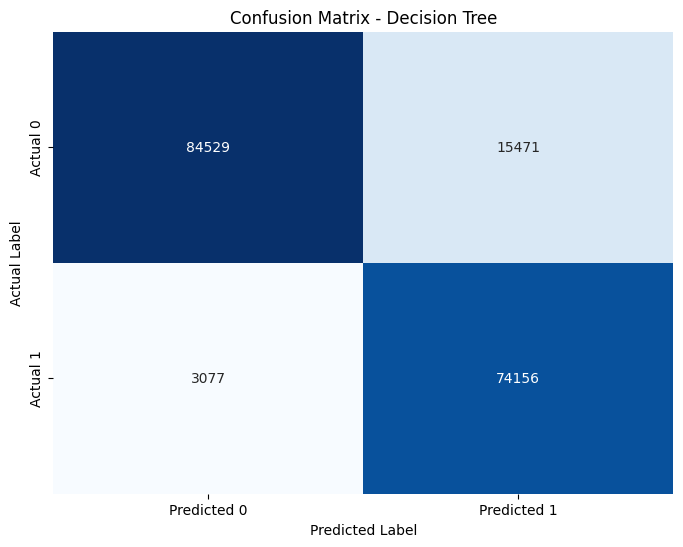

In [87]:
# Displaying confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bestdt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [88]:
# # Classifier Libraries
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

In [89]:
# # Let's implement simple classifiers
# classifiers = {
#     "LogisiticRegression": LogisticRegression(),
#     "Support Vector Classifier": SVC(),
#     "DecisionTreeClassifier": DecisionTreeClassifier()
# }

# for key, classifier in classifiers.items():
#     classifier.fit(X_train, y_train)
#     training_score = cross_val_score(classifier, X_train, y_train, cv=5)
#     print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
#     test_score = classifier.score(X_test, y_test)
#     print("Classifiers: ", classifier.__class__.__name__, "Has a test score of", round(test_score, 2) * 100, "% accuracy score\n")

## **XGBoost**

[0]	train-logloss:0.61610	train-error:0.43577	test-logloss:0.61700	test-error:0.43577
[1]	train-logloss:0.56915	train-error:0.12667	test-logloss:0.57097	test-error:0.13039
[2]	train-logloss:0.51975	train-error:0.11275	test-logloss:0.52273	test-error:0.11870
[3]	train-logloss:0.48613	train-error:0.10971	test-logloss:0.49024	test-error:0.11697
[4]	train-logloss:0.44962	train-error:0.10698	test-logloss:0.45490	test-error:0.11450
[5]	train-logloss:0.42770	train-error:0.10548	test-logloss:0.43406	test-error:0.11437
[6]	train-logloss:0.39875	train-error:0.10028	test-logloss:0.40608	test-error:0.11139
[7]	train-logloss:0.37375	train-error:0.09521	test-logloss:0.38204	test-error:0.10939
[8]	train-logloss:0.35722	train-error:0.09796	test-logloss:0.36656	test-error:0.11035
[9]	train-logloss:0.33736	train-error:0.09348	test-logloss:0.34770	test-error:0.10878
[10]	train-logloss:0.31994	train-error:0.08840	test-logloss:0.33130	test-error:0.10673
[11]	train-logloss:0.30894	train-error:0.09246	test-l

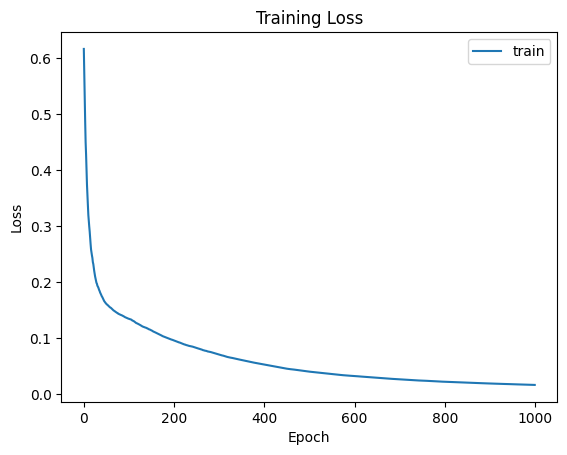

In [90]:
# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1
}

# Train the XGBoost model and record the evaluation results
num_rounds = 1000
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)

# Evaluate the XGBoost model
y_pred = bst.predict(dtest)
y_pred = np.round(y_pred)
test_score = accuracy_score(y_test, y_pred)
print("XGBoost has a test score of", round(test_score, 2) * 100, "% accuracy score")

# Extract the training loss from the evaluation results
train_loss = eval_results['train']['logloss']

# Plot the training loss curve
plt.plot(train_loss, label='train')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## **Some Other Classifiers**
#### **1. XGBoost**
#### **2. Random Forest**
#### **3. Extra Tree Classifier**

In [92]:
# Create pipelines for XGBoost, RandomForest, and ExtraTrees classifiers
pipelines = {
    'XGBoost': Pipeline([('scaler', RobustScaler()), ('classifier', XGBClassifier())]),
    'Random Forest': Pipeline([('scaler', RobustScaler()), ('classifier', RandomForestClassifier())]),
    'ExtraTreesClassifier': Pipeline([('scaler', RobustScaler()), ('classifier', ExtraTreesClassifier())]),
}

# Fit and evaluate XGBoost, RandomForest, and ExtraTrees classifiers
results = {}

for classifier_name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)

        # Training results
        y_train_pred = pipeline.predict(X_train)
        train_precision = round(precision_score(y_train, y_train_pred, average="weighted") * 100, 1)
        train_recall = round(recall_score(y_train, y_train_pred, average="weighted") * 100, 1)
        train_f1 = round(f1_score(y_train, y_train_pred, average="weighted") * 100, 1)
        train_conf_matrix = confusion_matrix(y_train, y_train_pred)
        train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

        # Testing results
        y_test_pred = pipeline.predict(X_test)
        test_precision = round(precision_score(y_test, y_test_pred, average="weighted") * 100, 1)
        test_recall = round(recall_score(y_test, y_test_pred, average="weighted") * 100, 1)
        test_f1 = round(f1_score(y_test, y_test_pred, average="weighted") * 100, 1)
        test_conf_matrix = confusion_matrix(y_test, y_test_pred)
        test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)

        results[classifier_name] = {
            'training': {
                'precision': train_precision,
                'recall': train_recall,
                'f1-score': train_f1,
                'confusion_matrix': train_conf_matrix,
                'classification_report': train_classification_report
            },
            'testing': {
                'precision': test_precision,
                'recall': test_recall,
                'f1-score': test_f1,
                'confusion_matrix': test_conf_matrix,
                'classification_report': test_classification_report
            }
        }


Algorithm: XGBoost
      Metric  Training  Testing
0  Precision      91.5     91.0
1     Recall      90.9     90.3
2   F1-score      90.9     90.4




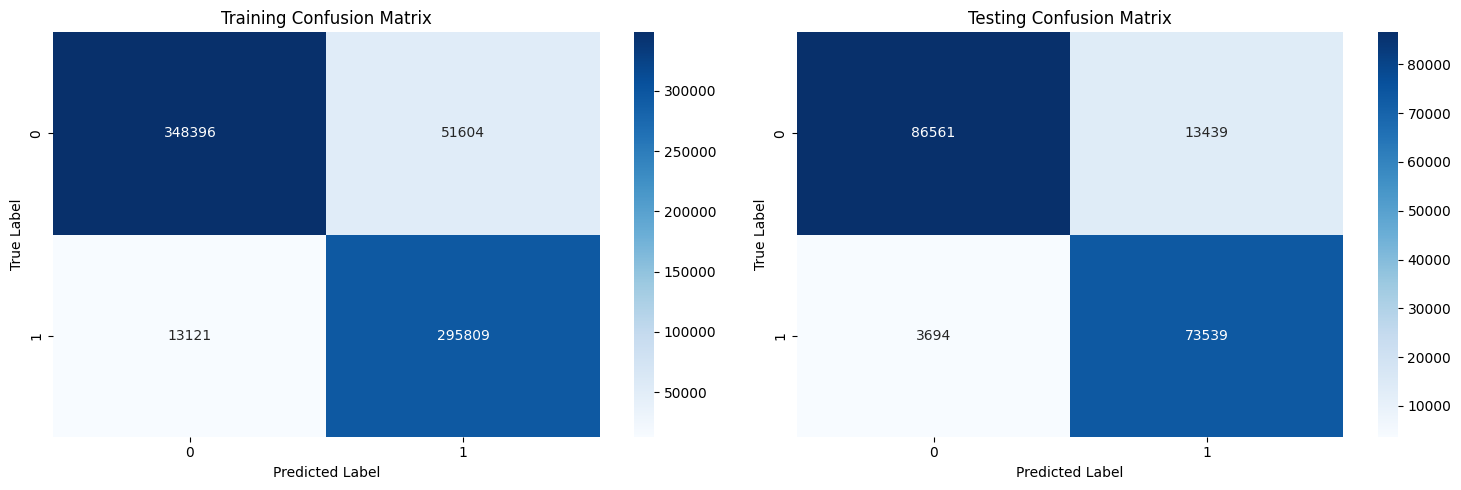

Algorithm: Random Forest
      Metric  Training  Testing
0  Precision     100.0     90.2
1     Recall     100.0     90.0
2   F1-score     100.0     90.0




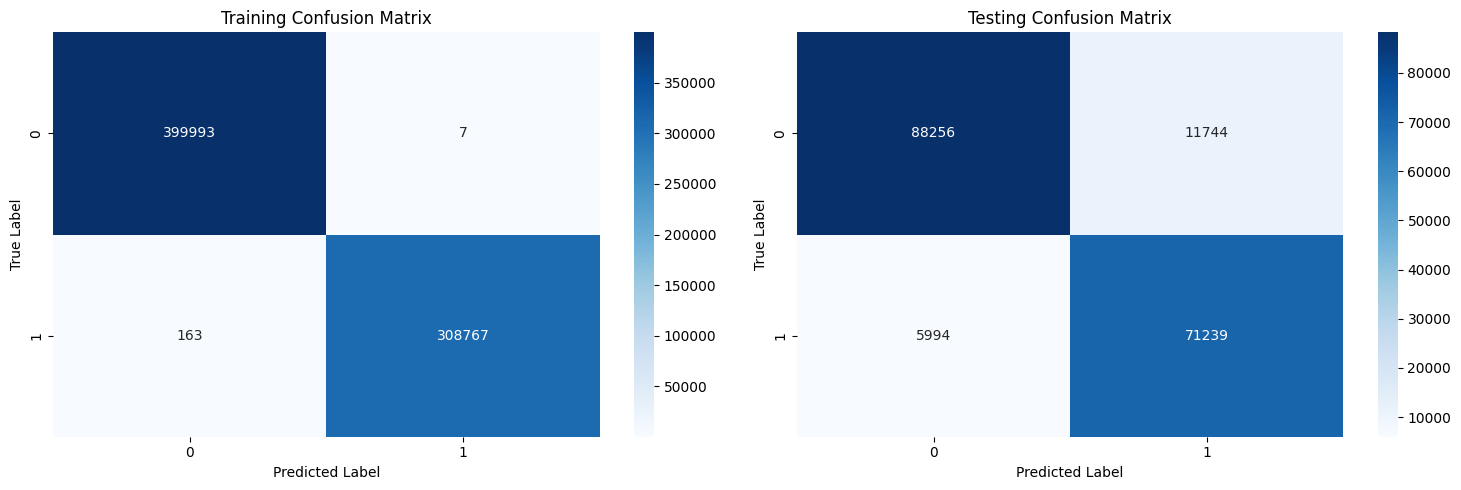

Algorithm: ExtraTreesClassifier
      Metric  Training  Testing
0  Precision     100.0     88.9
1     Recall     100.0     88.8
2   F1-score     100.0     88.8




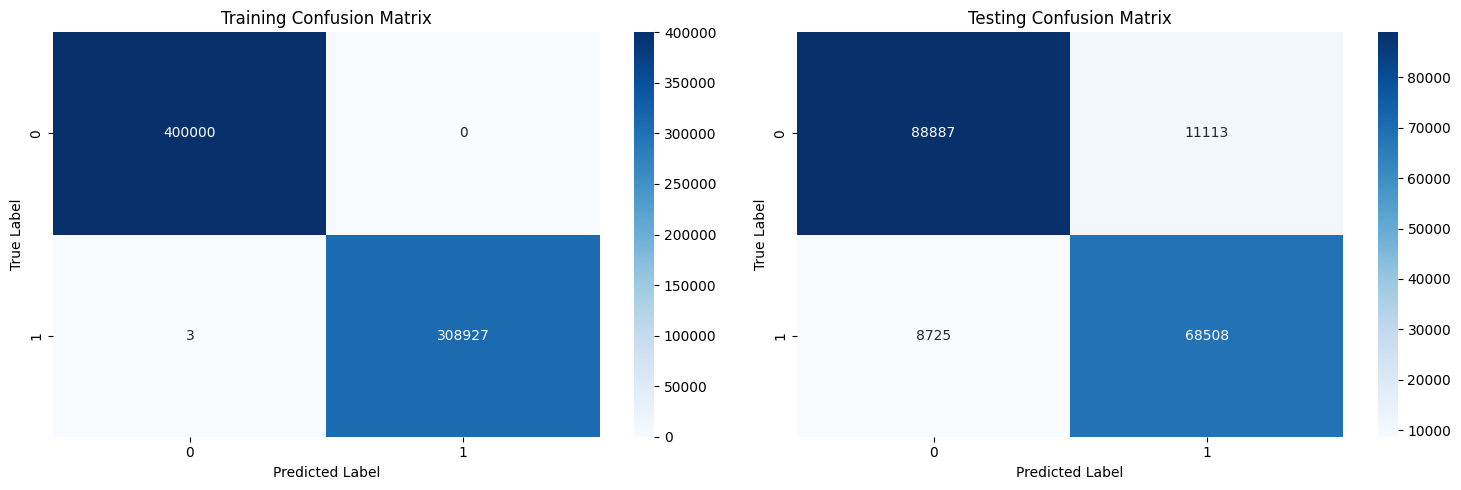

In [93]:
# Plot confusion matrices and display DataFrame for each algorithm
for classifier_name, metrics in results.items():
    print(f"Algorithm: {classifier_name}")

    # Display DataFrame
    df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-score'],
        'Training': [metrics['training']['precision'], metrics['training']['recall'], metrics['training']['f1-score']],
        'Testing': [metrics['testing']['precision'], metrics['testing']['recall'], metrics['testing']['f1-score']]
    })
    print(df)
    print("\n")

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Training confusion matrix
    sns.heatmap(metrics['training']['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Training Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Testing confusion matrix
    sns.heatmap(metrics['testing']['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Testing Confusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [94]:
# Initialize a list to store the scores
all_scores = []

# Iterate over the results
for classifier_name, metrics in results.items():
    # Append the scores to the list
    all_scores.append({
        'Algorithm': classifier_name,
        'Training Precision': metrics['training']['precision'],
        'Testing Precision': metrics['testing']['precision'],
        'Training Recall': metrics['training']['recall'],
        'Testing Recall': metrics['testing']['recall'],
        'Training F1-score': metrics['training']['f1-score'],
        'Testing F1-score': metrics['testing']['f1-score']
    })

# Create a DataFrame from the scores list
scores_df = pd.DataFrame(all_scores)

# Sort the DataFrame by the 'Testing F1-score' column in descending order
scores_sorted = scores_df.sort_values(by='Testing F1-score', ascending=False)

# Display the sorted DataFrame
scores_sorted

,Algorithm,Training Precision,Testing Precision,Training Recall,Testing Recall,Training F1-score,Testing F1-score
0,XGBoost,91.5,91.0,90.9,90.3,90.9,90.4
1,Random Forest,100.0,90.2,100.0,90.0,100.0,90.0
2,ExtraTreesClassifier,100.0,88.9,100.0,88.8,100.0,88.8


## **Some codes for future use**

### Saving the Model in Joblib and Pickle format

In [ ]:
# import pickle
# import joblib

# # Save the trained model using joblib
# joblib.dump(xgb_model, 'aml_model.joblib')


# # Save the trained model using pickle
# with open('aml_model.pkl', 'wb') as file:
#     pickle.dump(xgb_model, file)

### Load the pickle model

In [ ]:
# import pickle

# # Load the trained model using pickle
# with open('aml_model.pkl', 'rb') as file:
#     loaded_model_pickle = pickle.load(file)

### Make Predictions on the Pickle model

In [ ]:
# # Make predictions using the loaded model from pickle
# predictions_pickle = loaded_model_pickle.predict(X_test)

In [ ]:


# print(predictions_pickle[:50])



### Load the Joblib model

In [ ]:
# import joblib

# # Load the trained model using joblib
# loaded_model_joblib = joblib.load('aml_model.joblib')

### Make predictions on the joblib model

In [ ]:


# # Make predictions using the loaded model from joblib
# predictions_joblib = loaded_model_joblib.predict(X_test)



In [ ]:


# print(predictions_joblib[:50])

